Оценённая тета: [5.26999342 2.48865294]
Оценённая дельта: 1.9030051300588813
0.44056


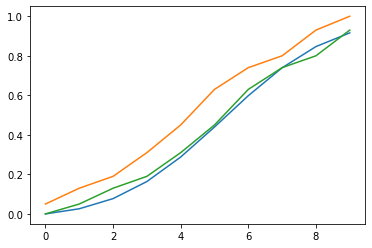

In [25]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

def normp(x,t1,t2):
    return np.exp(-(x-t1)**2/(2*t2**2))/(t2*(2*np.pi)**0.5)

def tetas(x):
    def L(t):
        def f(x):
            return normp(x,t[0],t[1])
        l = 1
        for i in range(10):
            st = 0
            for v in x:
                if i <= v < i+1:
                    st+=1
            v, err = integrate.quad(f, i, i+1)
            l = l*v**st
        return -l*10**110
    
    x0 = np.array([5,5])
    res = minimize(L, x0, method='nelder-mead')
    return res.x

def bootstrap(n, teta, d, kol):
    deltas = []
    
    for k in range(kol):
        a = norm.rvs(loc=teta[0], scale=teta[1], size=n)
        a = [max(0,min(9,int(c))) for c in a]
        x = np.array(a)
        t1 = sum(x)/n
        t2 = sum((x - t1)**2)/(n-1)
        teta_oc = [t1, t2]
        
        def integrand(x):
            global teta_oc
            return normp(x,teta_oc[0],teta_oc[1])
        
        ns = np.array([a.count(i) for i in range(10)])
        
        F = []
        for i in range(10):
            v, err = integrate.quad(integrand, 0, i)
            F.append(v)
        FF = np.array([F,F])
        
        F_oc = np.array([[sum(ns[0:i]) for i in range(10)]+ns,[sum(ns[0:i]) for i in range(10)]])/n
        
        delta_oc = n**0.5*np.max(np.abs(FF-F_oc))
        
        deltas.append(delta_oc)
        
        #plt.plot(F)
        #plt.plot(F_oc[0])
        #plt.plot(F_oc[1])
        
    deltas.sort()
    k=0
    while deltas[k]<d:
        k+=1
    return (k-1)/kol


n = 100
xs = np.linspace(0,9,10)
ns = np.array([5,8,6,12,14,18,11,6,13,7])
x = []
for i in range(10):
    for j in range(ns[i]):
        x.append(i)
x = np.array(x)

#t1 = sum(x)/n
#t2 = (sum((x - t1)**2)/(n-1))**0.5
#teta_oc = [t1, t2]
teta_oc = tetas(x)
print(f"Оценённая тета: {teta_oc}")

def integrand(x):
    global teta_oc
    return normp(x,teta_oc[0],teta_oc[1])

F = []
for i in range(10):
    v, err = integrate.quad(integrand, 0, i)
    F.append(v)
F = np.array(F)
FF = np.array([F,F])
        
F_oc = np.array([[sum(ns[0:i]) for i in range(10)]+ns,[sum(ns[0:i]) for i in range(10)]])/n

plt.plot(F)
plt.plot(F_oc[0])
plt.plot(F_oc[1])

delta_oc = n**0.5*np.max(np.abs(FF-F_oc))
print(f"Оценённая дельта: {delta_oc}")

pval = bootstrap(n, teta_oc, delta_oc, 50000)
print(pval)